In [198]:
import pandas as pd
import duckdb
import os
import os, json
from PyQt5.QtSql import QSqlDatabase, QSqlTableModel
from uuid import uuid4
import pandas as pd
pd.set_option("display.max_colwidth", 200)
#pd.set_option("display.width", 500)  # adjusts total line width before wrapping
import numpy as np
import pickle
from sentence_transformers import SentenceTransformer
import faiss
from sklearn.preprocessing import normalize
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import normalize

from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

import duckdb
import unicodedata
from transformers import AutoTokenizer, AutoModel
import importlib
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import h5py  # or np.save

import faiss

from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

conn = duckdb.connect('/srv/data/grela/grela_v0-3.duckdb', read_only=True)

In [172]:
# our own embedding functions
import helper_functions
importlib.reload(helper_functions)

<module 'helper_functions' from '/home/jupyter-vojta/notebooks/enemy-christianity/scripts/helper_functions.py'>

In [173]:
try:
    file_data = json.load(open(os.path.expanduser("~/ServiceAccountsKey.json")))
    # (2) transform the content into crendentials object
    credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
    scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
    gc = gspread.Client(auth=scoped_credentials)
    enemy_gs = gc.open_by_url("https://docs.google.com/spreadsheets/d/1ENbQuxY_U8W0sKHtiN348AS7KS9pxKjnbSg18KuUs7U/edit?usp=sharing")
except:
    pass

## Load verses with embeddings

In [180]:
verses_merged = pd.read_parquet("../data/verses_merged.parquet")

In [188]:
verses_merged["primary_category"][:10]

0    5
1    2
2    2
3    5
4    5
5    5
6    7
7    4
8    4
9    2
Name: primary_category, dtype: Int64

In [181]:
verses_merged.columns

Index(['grela_id', 'book_name', 'chapter', 'verse', 'primary_category',
       'additional_categories', 'cat1_polemical terms', 'cat2_polemical terms',
       'cat3_polemical terms', 'cat4_polemical terms', 'cat5_polemical terms',
       'cat6_polemical terms', 'cat7_polemical terms', 'chapterverse',
       'verse_text', 'tokens', 'sent_emb_agbert', 'x', 'y', 'unpolemical',
       'lemmatized_sentence', 'lem_sent_emb_agbert'],
      dtype='object')

## Multiclass classifier dev

In [185]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# basic experiments with contextual embeddings

lr = LogisticRegression(
    max_iter=4000,
    solver="lbfgs",
    n_jobs=-1)

mlp = MLPClassifier(hidden_layer_sizes=(512, 128),
                    activation='relu',
                    solver='adam',
                    alpha=1e-4,
                    max_iter=500,
                    random_state=42)

clfs = {"lr" : lr, "mlp" : mlp}

In [204]:
# Embedding columns to evaluate
emb_cols = [
    "lem_sent_emb_agbert",        # target word embeddings (AGBERT)
    "sent_emb_agbert",  # sentence embeddings (AGBERT)
]

In [190]:
subset = verses_merged[verses_merged["primary_category"]!=7]
y = subset["primary_category"].values


# Results
results = []
conf_mats = {}

for emb_col in emb_cols:
    X = np.stack(subset[emb_col].values)
    for clf_name, clf in clfs.items():
        y_pred = cross_val_predict(clf, X, y, cv=cv)
        acc = accuracy_score(y, y_pred)
        f1 = f1_score(y, y_pred, average="macro")

        results.append({
            "embedding": emb_col,
            "classifier": clf_name,
            "accuracy": acc,
            "F1 (macro)": f1
        })

        # Save confusion matrix
        cm = confusion_matrix(y, y_pred, labels=np.unique(y))
        conf_mats[(emb_col, clf_name)] = cm

# Pretty results table
results_categories_df = pd.DataFrame(results)
print(results_categories_df)

             embedding classifier  accuracy  F1 (macro)
0  lem_sent_emb_agbert         lr  0.540881    0.193831
1  lem_sent_emb_agbert        mlp  0.598383    0.411775
2      sent_emb_agbert         lr  0.533693    0.189302
3      sent_emb_agbert        mlp  0.628032    0.453162


In [199]:


def pretty_confmat(y_true, y_pred, *,
                   classes_order=None,
                   class_name_map=None,
                   title="Confusion Matrix",
                   normalize=True,
                   figsize=(8.5, 7),
                   savepath=None,
                   dpi=200):

    from sklearn.metrics import confusion_matrix
    import numpy as np

    if classes_order is None:
        classes_order = np.unique(np.concatenate([y_true, y_pred]))

    cm = confusion_matrix(y_true, y_pred, labels=classes_order)

    if normalize:
        with np.errstate(invalid="ignore", divide="ignore"):
            cm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    display_labels = [
        class_name_map.get(int(c), str(c)) if class_name_map else str(c)
        for c in classes_order
    ]
    supports = cm.sum(axis=1) if not normalize else confusion_matrix(y_true, y_true, labels=classes_order).sum(axis=1)
    ytick_labels = [f"{lbl}  (n={n})" for lbl, n in zip(display_labels, supports)]

    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        cm, annot=True, fmt=".2f" if normalize else "d",
        cmap="YlGnBu",  # much softer palette
        linewidths=0.3, linecolor="white",
        cbar_kws={"shrink": 0.8, "label": "Proportion" if normalize else "Count"},
        xticklabels=display_labels, yticklabels=ytick_labels,
        square=True
    )
    ax.set_xlabel("Predicted label", fontsize=11)
    ax.set_ylabel("True label", fontsize=11)
    ax.set_title(title, fontsize=14, pad=12)
    plt.xticks(rotation=35, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()

    if savepath:
        plt.savefig(savepath, dpi=dpi, bbox_inches="tight")
    plt.show()

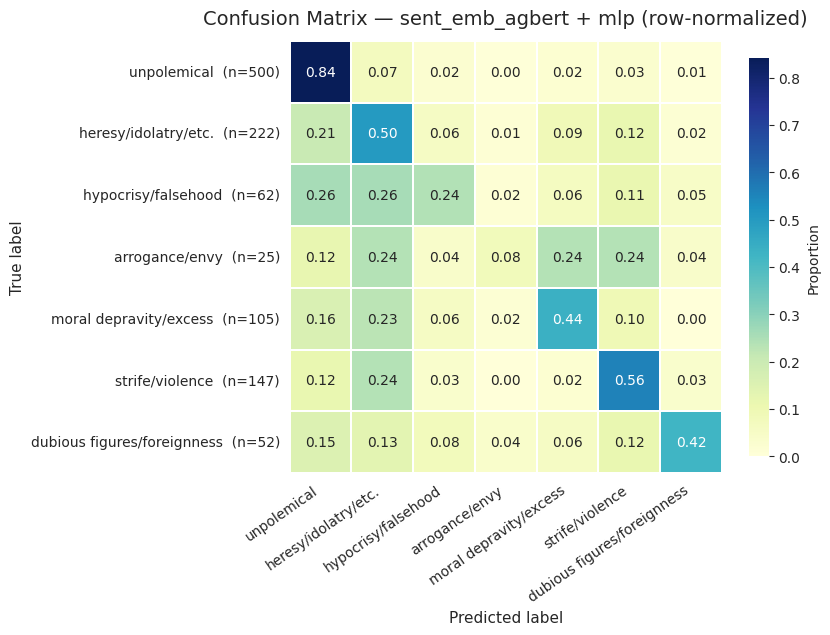

In [211]:
# pick the run you want to visualize
emb_col  = "sent_emb_agbert"
clf_name = "mlp"
key = (emb_col, clf_name)

y_true = subset["primary_category"].values
y_pred = cross_val_predict(clfs[clf_name], np.stack(subset[emb_col].values), y_true, cv=cv)

class_names_map = {
    -1: "unpolemical",
     1: "heresy/idolatry/etc.",
     2: "hypocrisy/falsehood",
     3: "arrogance/envy",
     4: "moral depravity/excess",
     5: "strife/violence",
     6: "dubious figures/foreignness",
}
order = [-1, 1, 2, 3, 4, 5, 6]

pretty_confmat(
    y_true, y_pred,
    classes_order=order,
    class_name_map=class_names_map,
    title=f"Confusion Matrix — {emb_col} + {clf_name} (row-normalized)",
    normalize=True,  # set False for counts
    savepath=None    # e.g. "cm_sent_agbert_mlp.png"
)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def pretty_confmat_from_matrix(
    cm,
    labels,
    *,
    class_name_map=None,
    title="Confusion Matrix",
    normalize=False,
    savepath=None,
    cmap="Blues",
):
    """
    Plot a confusion matrix you already computed.

    Args:
        cm (np.ndarray): confusion matrix (shape [n_classes, n_classes])
        labels (list/array): class ids in the same order as rows/cols of cm
        class_name_map (dict): optional {id: pretty_name}
        normalize (bool): row-normalize (percentages) if True
        savepath (str|None): if set, saves the figure
        cmap (str): matplotlib colormap
    """
    cm = np.asarray(cm, dtype=float)
    if normalize:
        row_sums = cm.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1.0
        cm = cm / row_sums

    display_labels = [class_name_map.get(int(c), str(c)) if class_name_map else str(c)
                      for c in labels]

    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(ax=ax, cmap=cmap, colorbar=True,
              values_format=".2f" if normalize else "d")

    ax.set_title(title)
    plt.xticks(rotation=40, ha="right")
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=200)
    plt.show()

## Binary classifier dev

In [209]:

    # Embedding columns to evaluate
emb_cols = [
        "lem_sent_emb_agbert",        # target word embeddings (AGBERT)
        "sent_emb_agbert",  # sentence embeddings (AGBERT)
    ]

subset = verses_merged[verses_merged["primary_category"] != 7]
y = subset["unpolemical"].values

    # Results
results = []
conf_mats = {}

for emb_col in emb_cols:
        X = np.stack(subset[emb_col].values)
        for clf_name, clf in clfs.items():
            y_pred = cross_val_predict(clf, X, y, cv=cv)
            acc = accuracy_score(y, y_pred)
            f1 = f1_score(y, y_pred, average="macro")

            results.append({
                "embedding": emb_col,
                "classifier": clf_name,
                "accuracy": acc,
                "F1 (macro)": f1
            })

            # Save confusion matrix
            cm = confusion_matrix(y, y_pred, labels=np.unique(y))
            conf_mats[(emb_col, clf_name)] = cm

# Pretty results table
results_categories_df = pd.DataFrame(results)
print(results_categories_df)

             embedding classifier  accuracy  F1 (macro)
0  lem_sent_emb_agbert         lr  0.760108    0.753665
1  lem_sent_emb_agbert        mlp  0.814915    0.813253
2      sent_emb_agbert         lr  0.807727    0.801508
3      sent_emb_agbert        mlp  0.831986    0.829804


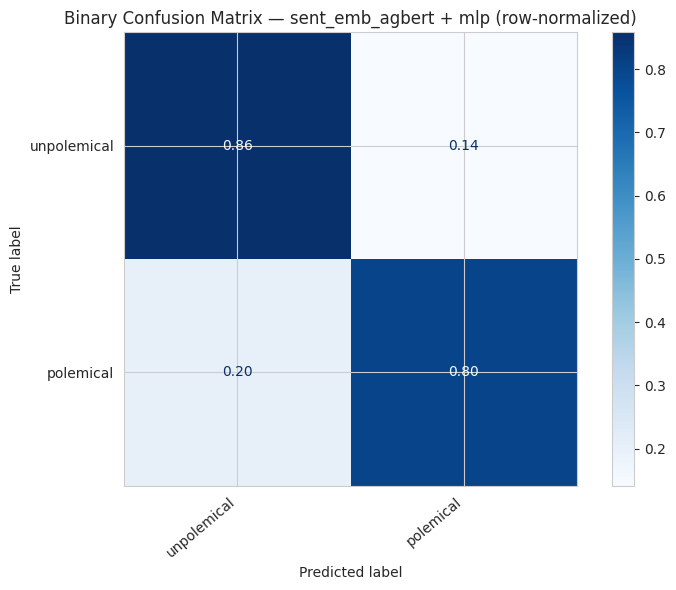

In [212]:

def pretty_confmat_from_matrix(
    cm,
    labels,
    *,
    class_name_map=None,
    title="Confusion Matrix",
    normalize=False,
    savepath=None,
    cmap="Blues",
):
    """
    Plot a confusion matrix you already computed.

    Args:
        cm (np.ndarray): confusion matrix (shape [n_classes, n_classes])
        labels (list/array): class ids in the same order as rows/cols of cm
        class_name_map (dict): optional {id: pretty_name}
        normalize (bool): row-normalize (percentages) if True
        savepath (str|None): if set, saves the figure
        cmap (str): matplotlib colormap
    """
    cm = np.asarray(cm, dtype=float)
    if normalize:
        row_sums = cm.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1.0
        cm = cm / row_sums

    display_labels = [class_name_map.get(int(c), str(c)) if class_name_map else str(c)
                      for c in labels]

    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(ax=ax, cmap=cmap, colorbar=True,
              values_format=".2f" if normalize else "d")

    ax.set_title(title)
    plt.xticks(rotation=40, ha="right")
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=200)
    plt.show()

# choose the binary run you stored, e.g. ('sent_emb_agbert', 'mlp')
key = ("sent_emb_agbert", "mlp")
cm = conf_mats[key]                 # shape (2, 2)

labels = [-1, 1]                    # row/col order of cm
name_map = {-1: "unpolemical", 1: "polemical"}

pretty_confmat_from_matrix(
    cm, labels,
    class_name_map=name_map,
    title="Binary Confusion Matrix — sent_emb_agbert + mlp (row-normalized)",
    normalize=True,   # set False for counts
    cmap="Blues"
)

In [ ]:
# let's now train and store our winning model

import joblib

# Train data (use the exact feature the winner used)
subset = verses_merged[verses_merged["primary_category"] != 7].copy()
X_train = np.stack(subset["sent_emb_agbert"].values).astype("float32")
y_train = subset["unpolemical"].astype(int).values   # 1 = unpolemical, 0 = polemical

best_clf = MLPClassifier(
    hidden_layer_sizes=(512, 128),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    max_iter=500,
    random_state=42
)
best_clf.fit(X_train, y_train)

# Save the model for reuse
joblib.dump(best_clf, "models/polemical_bin_mlp_agbert.joblib")

## Embeddings for grouped

In [222]:
with open ("/srv/data/enemy-christ/large-data/grouped_df.pkl", "rb") as f:
    grouped = pickle.load(f)

/tmp/ipykernel_2935421/57775235.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  grouped = pickle.load(f)


In [223]:
len(grouped)

1169805

In [224]:
# exclude GNT
# grouped = grouped[~grouped["sentence_id"].str.startswith("lagt_tlg0031")]

In [225]:
texts = (
    helper_functions.normalize_greek(t, strip_diacritics=True)
    for t in grouped["sentence_text"].tolist()
)

In [ ]:
import h5py  # or np.save
import torch


texts = grouped["sentence_text"].apply(
    lambda t: helper_functions.normalize_greek(t, strip_diacritics=True)
).tolist()

N = len(texts)
dim = model_agbert.config.hidden_size           # e.g. 768
outer_batch = 4096                              # how many sentences per outer chunk
inner_batch = 256                               # passed into your helper (per-model batch)
emb_path = "../data/large-data/greek_sent_embeddings.memmap"

# pre-allocate memory-mapped array on disk
emb_mm = np.memmap(emb_path, dtype="float32", mode="w+", shape=(N, dim))

offset = 0
for i in range(0, N, outer_batch):
    chunk = texts[i:i+outer_batch]

    # compute embeddings in this chunk
    embs = helper_functions.bert_sentence_embeddings(
        chunk,
        tokenizer=tokenizer_agbert,
        model=model_agbert,
        device="cpu",                 # or "cuda" if you want GPU
        batch_size=inner_batch,
        max_length=tokenizer_agbert.model_max_length,
        l2_normalize=True,
    )                                 # embs shape: [len(chunk), dim]

    # write directly to disk-backed array
    emb_mm[offset:offset+len(chunk)] = embs
    offset += len(chunk)

    if i % 100_000 == 0:
        print(f"Processed {i}/{N}")

# ensure data are flushed
emb_mm.flush()
del emb_mm

Processed 0/1169805


In [ ]:
# create faiss index for all grouped

# open your memmap
emb_read = np.memmap(
    "../data/large-data/greek_sent_embeddings.memmap",
    dtype="float32",
    mode="r",
    shape=(N, dim),  # same as you saved earlier
)

# dimension = embedding size
d = emb_read.shape[1]

# build FAISS index (cosine similarity since we L2-normalized)
index = faiss.IndexFlatIP(d)
index.add(emb_read)

# save index
faiss.write_index(index, "../data/large-data/grouped_emb.index")

In [ ]:
# create faiss index for GNT

# Convert list of numpy arrays to a 2D float32 array
verse_embs = np.stack(verses_merged["sent_emb_agbert"].values).astype("float32")

# Dimension of embeddings
d = verse_embs.shape[1]

# Build FAISS index (cosine similarity if embeddings are L2-normalized)
index_nt = faiss.IndexFlatIP(d)
index_nt.add(verse_embs)

# Save to disk
faiss.write_index(index_nt, "../data/large-data/nt_verses_emb.index")

print(f"Indexed {index_nt.ntotal} NT verses with dim={d}")

In [ ]:
# !!!!!!!!!!!!!!!!
# do not forget about removing GNT from grouped:
# ~grouped["sentence_id"].str.startswith("lagt_tlg0031")

In [ ]:
# let's now train and store our winning model

import joblib

# Train data (use the exact feature the winner used)
subset = verses_merged[verses_merged["primary_category"] != 7].copy()
X_train = np.stack(subset["sent_emb_agbert"].values).astype("float32")
y_train = subset["unpolemical"].astype(int).values   # 1 = unpolemical, 0 = polemical

best_clf = MLPClassifier(
    hidden_layer_sizes=(512, 128),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    max_iter=500,
    random_state=42
)
best_clf.fit(X_train, y_train)

# Save the model for reuse
joblib.dump(best_clf, "models/polemical_bin_mlp_agbert.joblib")